In [1]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

In [3]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


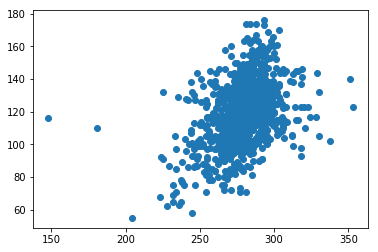

In [4]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [7]:
def mse(slope, intercept):
        x = baby.column(1) # gestational days
        y = baby.column(0) # birth weight
        fitted = slope*x+intercept
        return np.mean((y-fitted)**2)

# Minimize to find slope and intercept
baby_slope = minimize(rmse)[0]
baby_intercept = minimize(rmse)[1]
minimize(rmse)

array([ 0.4284037 , -0.07039869])

In the context of the data, interpret the intercept and slope. 

The slope matches the slight upward trend the data shown by the scatter plot. The intercept reflects the estimated birth weight for 0 gestational days. It would make sense that this value is approximately 0.

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using bootstrapping. 

In [10]:
# Create a mean squared error resample function to incorporate into bootstrap
def mse_resample(slope, intercept):
    x = resample.column(1)
    y = resample.column(0)
    fitted = slope*x+intercept
    return np.mean((y-fitted)**2)

# Bootstrap
slope_strap = []
for i in np.arange(2000):
    resample = baby.sample()
    slope_strap = np.append(slope_strap,minimize(mse_resample)[0])

print(np.mean(slope_strap))
print(percentile([2.5,97.5],slope_strap))

0.42966562779336404
[0.42509734 0.43223887]


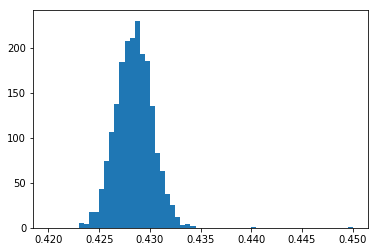

In [13]:
# Plotting the bootstrap
plt.hist(slope_strap,bins=np.arange(0.42,0.45,0.0005))
plt.show()

### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [17]:
avg_bw40 = baby_slope*(40*7)+baby_intercept
print('The expected average weight at 40 gestational weeks is',np.round(avg_bw40,5))

The expected average weight at 40 gestational weeks is 119.88264


Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

In [18]:
weight_strap = []
for i in np.arange(2000):
    resample = baby.sample()
    baby_slope = minimize(mse_resample)[0]
    baby_intercept = minimize(mse_resample)[1]
    weight_strap = np.append(weight_strap,baby_slope*(40*7)+baby_intercept)
    
percentile([2.5,97.5],weight_strap)

array([118.9161672, 120.8863306])

This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. The interval says that there is a 2.5% chance that the actual birth weight is less than 118.92  or more than 120.89 for a baby after 40 weeks of gestation.

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

[ 86.1431926  153.28286289]


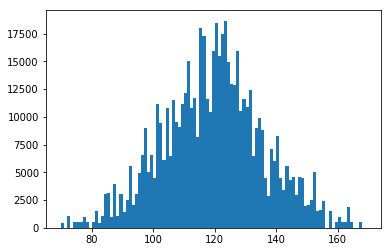

In [25]:
# Re-establish the regression line for the original data set
baby_slope = minimize(rmse)[0]
baby_intercept = minimize(rmse)[1]

# Data residuals in a table
residuals = baby.column(0) - (baby_slope*baby.column(1)+baby_intercept)
tbl_r = Table().with_column('residuals',residuals)

# Prediction interval
pred_bw = []
for i in np.arange(500):
    r_sample = tbl_r.sample()
    pred_bw = np.append(pred_bw,r_sample.column(0) + (baby_slope*(40*7)+baby_intercept))
    
# Interval
print(percentile([2.5,97.5],pred_bw))

# Plot
plt.hist(pred_bw,bins=np.arange(70,170,1))
plt.show()

It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [29]:
pred=baby_intercept+baby_slope*280
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=residuals/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(baby_intercept+baby_slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(baby_slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

array([ 85.892162  , 153.33577893])